In [ ]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [ ]:
import gym_fish

In [ ]:
from gym_fish.envs.lib import pyflare as fl

In [ ]:
Experiment_name = 'test chase'
Experiment_note = """

"""

In [ ]:
gpuId = 3
control_dt = 0.2
radius=1.0

max_time = 10

action_max= 2
couple_mode =  fl.COUPLE_MODE.TWO_WAY

wp= 1.0
wa=0.00001 
live_penality=-0.05

use_com=False
ratio = 0.005/control_dt*(max_time/10)
import torch
torch.cuda.set_device(gpuId)

In [ ]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

### Import Settings

In [ ]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [ ]:
fluid_json = json_folder+'fluid_param_test_chase.json'
rigid_json = json_folder+'rigids_4_30_chase.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

In [ ]:
def plot_infos(infos,title=None,reward_fig_name=None):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    if title:
        plt.title(title)
    if reward_fig_name:
        plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [ ]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [ ]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [ ]:
import gym
import numpy as np
from stable_baselines3 import SAC

## RL Begin

In [ ]:
from gym_fish.envs.fish_env_chase import *
env=FishEnvChase(gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,
                    action_max=action_max,
                    rigid_json=rigid_json,use_com=use_com,
                    wp=wp,wa=wa,
                    fluid_json=fluid_json
                   ) 

env_test=FishEnvChase(gpuId=gpuId,
                    couple_mode=couple_mode,control_dt=control_dt,max_time=max_time,
                    action_max=action_max,
                    rigid_json=rigid_json,use_com=use_com,
                    wp=wp,wa=wa,
                    fluid_json=fluid_json
                   ) 

In [ ]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [ ]:
# policy_kwargs = dict(layers=[128,128])
model = SAC("MlpPolicy", 
             env, buffer_size=int(2e6*ratio), 
            learning_starts=int(2048*ratio), 
            batch_size=int(2048*ratio), 
            learning_rate=0.0003, 
             verbose=1,
#             policy_kwargs=policy_kwargs,
             tensorboard_log=network_folder+algofoler,
            )

In [ ]:
def evaluate_env(env_test,model,title,traj_fig_name,reward_fig_name,save=False,eval_trajs=1,render=False):
    obs = env_test.reset()
    dones = False
    infos = []
    reward = 0
    while not dones:
        action, _states = model.predict(obs, deterministic=True)
        if not save:
            obs, r, dones,info=env_test.step(action)
        else:
            obs, r, dones,info=env_test.stepSave(action,save_fluid=True)
        if render:
            env_test.render()
        reward=reward+r
        infos.append(info)
    plot_infos(infos,title=title,reward_fig_name=reward_fig_name)
    env_test.plot3d(title=title,fig_name = traj_fig_name)
    
    rewards= [reward]
    for i in range(eval_trajs-1):
        obs = env_test.reset()
        dones = False
        reward=0
        while not dones:
            action, _states = model.predict(obs, deterministic=True)
            obs, r, dones,_=env_test.step(action)
            reward=reward+r
        rewards.append(reward)
    print(np.mean(rewards))
    return np.mean(rewards)

### RL Train

In [ ]:
!./clean_visdata.sh

In [ ]:
timesteps = int(2e6*ratio)
step = int(20000*ratio)
length =int(timesteps/step) 
print(timesteps,step,length)
last_best_reward = -1e5
cur_steps = 0

---------------------------------
| time/              |          |
|    episodes        | 11       |
|    fps             | 0        |
|    time_elapsed    | 305      |
|    total timesteps | 184      |
| train/             |          |
|    actor_loss      | -6.17    |
|    critic_loss     | 0.211    |
|    ent_coef        | 0.961    |
|    ent_coef_loss   | -0.26    |
|    learning_rate   | 0.0003   |
|    n_updates       | 132      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 0        |
|    time_elapsed    | 335      |
|    total timesteps | 202      |
| train/             |          |
|    actor_loss      | -6.26    |
|    critic_loss     | 0.232    |
|    ent_coef        | 0.956    |
|    ent_coef_loss   | -0.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 150      |
---------------------------------
---------------------------------
| time/       

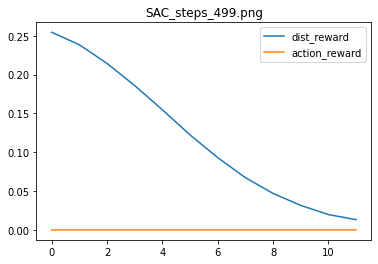

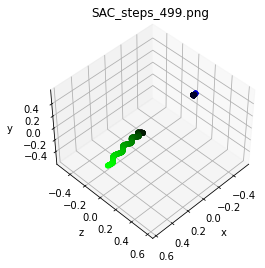

1.4421654569043603
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 29       |
|    fps             | 40       |
|    time_elapsed    | 12       |
|    total timesteps | 504      |
| train/             |          |
|    actor_loss      | -8.69    |
|    critic_loss     | 0.556    |
|    ent_coef        | 0.874    |
|    ent_coef_loss   | -0.908   |
|    learning_rate   | 0.0003   |
|    n_updates       | 452      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 30       |
|    fps             | 11       |
|    time_elapsed    | 47       |
|    total timesteps | 526      |
| train/             |          |
|    actor_loss      | -8.79    |
|    critic_loss     | 0.96     |
|    ent_coef        | 0.868    |
|    ent_coef_loss   | -0.954   |
|    learning_rate   | 0.0003   |
| 

---------------------------------
| time/              |          |
|    episodes        | 46       |
|    fps             | 1        |
|    time_elapsed    | 513      |
|    total timesteps | 810      |
| train/             |          |
|    actor_loss      | -10.8    |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.797    |
|    ent_coef_loss   | -1.5     |
|    learning_rate   | 0.0003   |
|    n_updates       | 758      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 47       |
|    fps             | 1        |
|    time_elapsed    | 559      |
|    total timesteps | 841      |
| train/             |          |
|    actor_loss      | -11.1    |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.79     |
|    ent_coef_loss   | -1.57    |
|    learning_rate   | 0.0003   |
|    n_updates       | 789      |
---------------------------------
---------------------------------
| time/       

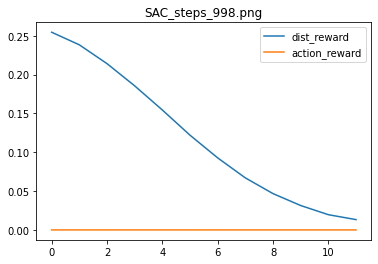

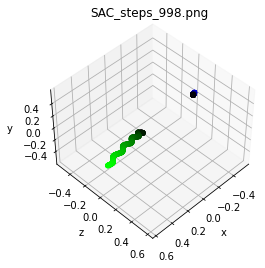

1.439157007773329
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 55       |
|    fps             | 84       |
|    time_elapsed    | 11       |
|    total timesteps | 1003     |
| train/             |          |
|    actor_loss      | -11.9    |
|    critic_loss     | 2.35     |
|    ent_coef        | 0.753    |
|    ent_coef_loss   | -1.87    |
|    learning_rate   | 0.0003   |
|    n_updates       | 951      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 56       |
|    fps             | 24       |
|    time_elapsed    | 40       |
|    total timesteps | 1021     |
| train/             |          |
|    actor_loss      | -11.7    |
|    critic_loss     | 3.09     |
|    ent_coef        | 0.749    |
|    ent_coef_loss   | -1.88    |
|    learning_rate   | 0.0003   |
|  

---------------------------------
| time/              |          |
|    episodes        | 72       |
|    fps             | 2        |
|    time_elapsed    | 512      |
|    total timesteps | 1307     |
| train/             |          |
|    actor_loss      | -13.5    |
|    critic_loss     | 2.69     |
|    ent_coef        | 0.687    |
|    ent_coef_loss   | -2.51    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1255     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 73       |
|    fps             | 2        |
|    time_elapsed    | 542      |
|    total timesteps | 1326     |
| train/             |          |
|    actor_loss      | -13.3    |
|    critic_loss     | 2.46     |
|    ent_coef        | 0.684    |
|    ent_coef_loss   | -2.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1274     |
---------------------------------
---------------------------------
| time/       

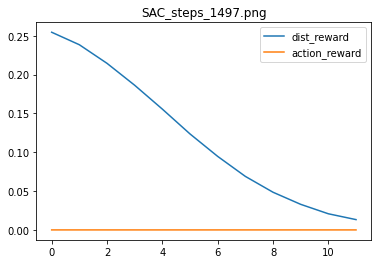

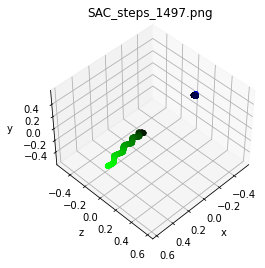

1.451516506078984
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 83       |
|    fps             | 89       |
|    time_elapsed    | 16       |
|    total timesteps | 1506     |
| train/             |          |
|    actor_loss      | -14.4    |
|    critic_loss     | 4.11     |
|    ent_coef        | 0.648    |
|    ent_coef_loss   | -2.81    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1454     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 84       |
|    fps             | 36       |
|    time_elapsed    | 41       |
|    total timesteps | 1521     |
| train/             |          |
|    actor_loss      | -13.9    |
|    critic_loss     | 4.1      |
|    ent_coef        | 0.645    |
|    ent_coef_loss   | -2.82    |
|    learning_rate   | 0.0003   |
|  

---------------------------------
| time/              |          |
|    episodes        | 100      |
|    fps             | 3        |
|    time_elapsed    | 533      |
|    total timesteps | 1822     |
| train/             |          |
|    actor_loss      | -15.4    |
|    critic_loss     | 1.77     |
|    ent_coef        | 0.591    |
|    ent_coef_loss   | -3.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 1770     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 101      |
|    fps             | 3        |
|    time_elapsed    | 567      |
|    total timesteps | 1843     |
| train/             |          |
|    actor_loss      | -15.7    |
|    critic_loss     | 4.53     |
|    ent_coef        | 0.587    |
|    ent_coef_loss   | -3.31    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1791     |
---------------------------------
---------------------------------
| time/       

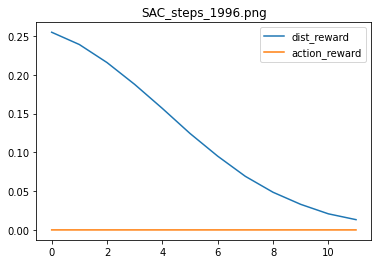

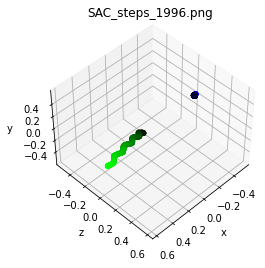

1.4570127068005259
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 110      |
|    fps             | 108      |
|    time_elapsed    | 18       |
|    total timesteps | 2005     |
| train/             |          |
|    actor_loss      | -15.5    |
|    critic_loss     | 3.13     |
|    ent_coef        | 0.56     |
|    ent_coef_loss   | -3.74    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1953     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 111      |
|    fps             | 44       |
|    time_elapsed    | 45       |
|    total timesteps | 2021     |
| train/             |          |
|    actor_loss      | -15.9    |
|    critic_loss     | 2.69     |
|    ent_coef        | 0.557    |
|    ent_coef_loss   | -3.77    |
|    learning_rate   | 0.0003   |
| 

---------------------------------
| time/              |          |
|    episodes        | 127      |
|    fps             | 4        |
|    time_elapsed    | 545      |
|    total timesteps | 2327     |
| train/             |          |
|    actor_loss      | -15.5    |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.509    |
|    ent_coef_loss   | -4.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 2275     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 128      |
|    fps             | 4        |
|    time_elapsed    | 575      |
|    total timesteps | 2345     |
| train/             |          |
|    actor_loss      | -16      |
|    critic_loss     | 3.76     |
|    ent_coef        | 0.507    |
|    ent_coef_loss   | -4.26    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2293     |
---------------------------------
---------------------------------
| time/       

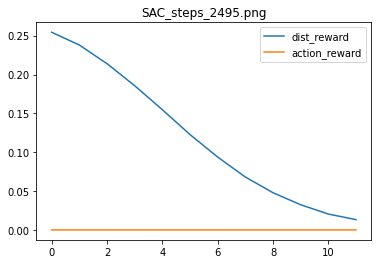

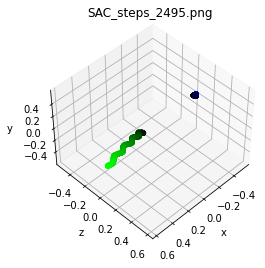

1.4446990028677247
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 136      |
|    fps             | 188      |
|    time_elapsed    | 13       |
|    total timesteps | 2501     |
| train/             |          |
|    actor_loss      | -16.6    |
|    critic_loss     | 2.07     |
|    ent_coef        | 0.484    |
|    ent_coef_loss   | -4.75    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2449     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 137      |
|    fps             | 56       |
|    time_elapsed    | 44       |
|    total timesteps | 2521     |
| train/             |          |
|    actor_loss      | -15.5    |
|    critic_loss     | 3.17     |
|    ent_coef        | 0.481    |
|    ent_coef_loss   | -4.58    |
|    learning_rate   | 0.0003   |
| 

---------------------------------
| time/              |          |
|    episodes        | 153      |
|    fps             | 5        |
|    time_elapsed    | 539      |
|    total timesteps | 2804     |
| train/             |          |
|    actor_loss      | -15.6    |
|    critic_loss     | 1.58     |
|    ent_coef        | 0.442    |
|    ent_coef_loss   | -5.24    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2752     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 154      |
|    fps             | 4        |
|    time_elapsed    | 569      |
|    total timesteps | 2822     |
| train/             |          |
|    actor_loss      | -15.3    |
|    critic_loss     | 2.73     |
|    ent_coef        | 0.44     |
|    ent_coef_loss   | -5.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 2770     |
---------------------------------
---------------------------------
| time/       

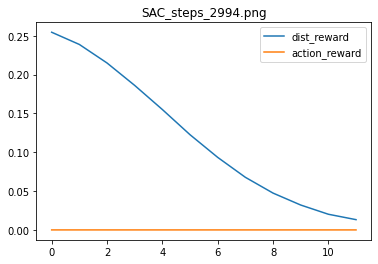

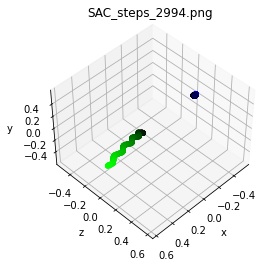

1.4453854074379435
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 164      |
|    fps             | 221      |
|    time_elapsed    | 13       |
|    total timesteps | 3000     |
| train/             |          |
|    actor_loss      | -15.1    |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.417    |
|    ent_coef_loss   | -5.59    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2948     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 165      |
|    fps             | 66       |
|    time_elapsed    | 45       |
|    total timesteps | 3020     |
| train/             |          |
|    actor_loss      | -13.7    |
|    critic_loss     | 1.54     |
|    ent_coef        | 0.415    |
|    ent_coef_loss   | -5.52    |
|    learning_rate   | 0.0003   |
| 

---------------------------------
| time/              |          |
|    episodes        | 181      |
|    fps             | 6        |
|    time_elapsed    | 528      |
|    total timesteps | 3308     |
| train/             |          |
|    actor_loss      | -13.5    |
|    critic_loss     | 1.05     |
|    ent_coef        | 0.381    |
|    ent_coef_loss   | -6.14    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3256     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 182      |
|    fps             | 5        |
|    time_elapsed    | 555      |
|    total timesteps | 3325     |
| train/             |          |
|    actor_loss      | -15.3    |
|    critic_loss     | 1.5      |
|    ent_coef        | 0.379    |
|    ent_coef_loss   | -6.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 3273     |
---------------------------------
---------------------------------
| time/       

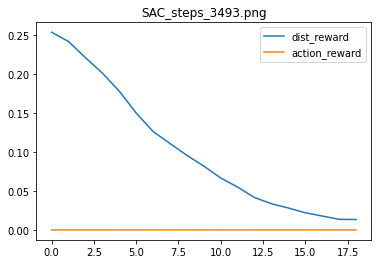

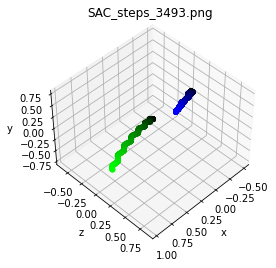

1.952523837211103
Logging to /root/sb3fish/output_data/2021-05-12/test chase_2021-05-12 10:31/networks/SAC/SAC_0
---------------------------------
| time/              |          |
|    episodes        | 191      |
|    fps             | 422      |
|    time_elapsed    | 8        |
|    total timesteps | 3495     |
| train/             |          |
|    actor_loss      | -13.8    |
|    critic_loss     | 0.947    |
|    ent_coef        | 0.36     |
|    ent_coef_loss   | -6.44    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3443     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 192      |
|    fps             | 95       |
|    time_elapsed    | 36       |
|    total timesteps | 3513     |
| train/             |          |
|    actor_loss      | -14.6    |
|    critic_loss     | 0.645    |
|    ent_coef        | 0.358    |
|    ent_coef_loss   | -6.51    |
|    learning_rate   | 0.0003   |
|  

In [ ]:
while cur_steps<timesteps:
    model.learn(total_timesteps=step, log_interval=1, reset_num_timesteps=False)
    cur_steps = cur_steps+step
    img_name =algo+ "_steps_{0}.png".format(cur_steps)
    model.save(network_folder+algofoler+'models/'+"_steps_{0}".format(cur_steps))
    rr = evaluate_env(env_test,model,title=img_name,traj_fig_name=network_folder+algofoler+'imgs/trajs/'+img_name,reward_fig_name=network_folder+algofoler+'imgs/rewards/'+img_name)
    if rr>last_best_reward:
        last_best_reward=rr
        model.save(network_folder+algofoler+'models/best')

In [ ]:
network_folder

In [ ]:
model = SAC.load(network_folder+algofoler+'models/'+"_steps_{0}".format(3493))

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(goal_pos,target_vel,step_budget):
#         print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
#         skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
#         skeleton_dynamics.getJoint("head").setVelocity(0,0)
#         skeleton_dynamics.getJoint("head").setVelocity(1,0)
#         joint_list =['spine','spine01','spine02','spine03']
#         for jnt_name in joint_list:
#             skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#             skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


#         skeleton_dynamics.update()
        env.set_task(goal_pos,target_vel,step_budget)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.init_pos*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
#         agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            action, _states = model.predict(obs, deterministic=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
        plot_infos(infos,title="str(theta)")
        env.plot3d()

In [ ]:
!./clean_visdata.sh

thetaa = 0
goal_dir = np.array([math.cos(thetaa),0,math.sin(thetaa)])
goal_pos = goal_dir*1
target_vel = 0.1
budget = 1.0
evaluate_traj(goal_pos,target_vel,budget)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()
t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 

env.set_task(goal_pos ,0.1,1.0)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
# env.set_datapath(store_folder+'/data/')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    action, _states = model.predict(obs, deterministic=True)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=True)
    
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.set_task(traj.getPose(t).getPosition() ,0.1,1.0)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
        
while env.rigid_data.rigidWorld.time<10:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
env.couple_mode =  fl.COUPLE_MODE.TWO_WAY
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)

# skeleton_dynamics.update()

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)


env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
while env.rigid_data.rigidWorld.time<3:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
# plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**2) for a in actions])
plt.plot(np.arange(0,len(actions),1),[ a[1] for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()